In [698]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import numpy as np
import pypsa
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import gurobipy as gp
from gurobipy import GRB
import cartopy.crs as ccrs
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [699]:
"load electricity demand data";
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

"Load the heat demand data";
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime


"Onshore Wind";
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
"Offshore Wind";
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
"Solar Data";
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)


In [700]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [701]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.00063 * delta_t**2

temp=data_T[country]

"This is in the link for the Heat Pump"

efficency = cop(temp).values

In [702]:
"Time Period in which our model is running";

hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

In [703]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015)

n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "nuclear")
n.add("Carrier","solar")
n.add("Carrier","heat")
n.add("Carrier","heat pump")

# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6
electrolyzer_capex = 350e3
h2_tank_capex = 8.4e3
fuel_cell_capex = 339e3

In [704]:
nodes = pd.Series( ['GBR', 'DNK',"NLD"]).values
neighbors =pd.Series(['DNK','NLD']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude
xs = {'GBR':-2.1698,
    'NLD':6.04248,
     "DNK":9.732249,
     }

# latitude
ys = {'GBR':53.243852,
      'NLD':52.709675,
     'DNK':55.990430,
     }

# this is in MW
Nuclear_Cap = {'GBR':10000,
      'NLD':500,
     'DNK':0,
     }

In [705]:
n.madd("Bus",
       names=["electrical bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       carrier="electricity")


Index(['electrical bus GBR', 'electrical bus DNK', 'electrical bus NLD'], dtype='object')

In [706]:
n.madd("Bus",
       names=["heat bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       )

Index(['heat bus GBR', 'heat bus DNK', 'heat bus NLD'], dtype='object')

In [707]:
n.madd("Bus", names = ["gas bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location =nodes,
       )

Index(['gas bus GBR', 'gas bus DNK', 'gas bus NLD'], dtype='object')

In [708]:
"Gas Storage for CHP is local for each country";
n.madd("Store", names = ["gas storage " + n for n in nodes], e_initial = 1e7, e_nom = 1e7,
       bus = ["gas bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location = nodes)


Index(['gas storage GBR', 'gas storage DNK', 'gas storage NLD'], dtype='object')

In [709]:
"Adding CHP";
n.madd("Link", names = ["CHP " + n for n in nodes],
       bus0 = "gas bus " + nodes,
       bus1 = "electrical bus " + nodes,
       bus2 = "heat bus " + nodes,
       p_nom_extendable = True,
       p_nom = 1000,
       marginal_cost = 80,
       efficiency = 0.4,
       efficiency2 = 0.4,
)  

Index(['CHP GBR', 'CHP DNK', 'CHP NLD'], dtype='object')

In [710]:
"Adding a Heat Pump";
n.madd("Link",
    names = ["heat pump " + n for  n in nodes],  # Heat pump names
    carrier = "heat pump", 
    bus0="electrical bus " + nodes,  # Electricity buses
    bus1="heat bus " + nodes,  # Heat buses
    p_nom_extendable=True,
    p_min_pu=-1,  # Nominal power
    efficiency=3,  # COP
    capital_cost=100,  # Marginal cost
)

Index(['heat pump GBR', 'heat pump DNK', 'heat pump NLD'], dtype='object')

In [711]:
n.consistency_check()

In [712]:
CF_wind_on = pd.DataFrame()
CF_wind_off = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind_on[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_wind_off[nodes[i]] = df_offshore[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

In [713]:
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
        [n + " onshorewind" for n in nodes],
        bus="electrical bus " + nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind_on[nodes].values)

capital_cost_offshorewind = annuity(25,0.07)*offshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
            [n + " offshorewind" for n in nodes],
            bus="electrical bus " + nodes,
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off[nodes].values)

"CCGT (Combine Cycle Gas Turbine) generator";
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
n.madd("Generator",
            [n + " CCGT" for n in nodes],
            bus="electrical bus " + nodes,
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)
"Solar";
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
n.madd("Generator",
                  [n + " solar" for n in nodes],
                  bus= "electrical bus " + nodes,
                  p_nom_extendable=True,
                  carrier="solar",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_solar,
                  marginal_cost = 0,
                  p_max_pu = CF_solar.values)

"Nuclear";
capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el

n.madd("Generator",
                  [n + " nuclear" for n in nodes],
                  bus = "electrical bus " + nodes,
                  p_nom_extendable=True,
                  carrier="nuclear",
                  p_nom_max = [Nuclear_Cap[n] for n in nodes],
                  capital_cost = capital_cost_nuclear,
                  marginal_cost = marginal_cost_nuclear)

Index(['GBR nuclear', 'DNK nuclear', 'NLD nuclear'], dtype='object')

In [714]:
"Electrical Loads";
n.madd(
    "Load",
    names=["electric load " + n for n in nodes],  # Unique names for electrical loads
    bus="electrical bus " + nodes,  # Assign to the corresponding electricity buses
    p_set=df_elec[nodes].values # Electricity demand values
  ) 

Index(['electric load GBR', 'electric load DNK', 'electric load NLD'], dtype='object', name='Load')

In [715]:
df_heat["GBR"].values

array([64062.547877, 65383.397149, 62689.53246 , ..., 78960.353024,
       81803.419959, 84607.981799])

In [716]:
"Heat Loads";
n.madd("Load",
       names = ["heat load " + n for n in nodes],
       bus= "heat bus " + nodes,
       p_set=df_heat[nodes].values)

Index(['heat load GBR', 'heat load DNK', 'heat load NLD'], dtype='object', name='Load')

In [717]:
n.consistency_check()

In [718]:
n.consistency_check()

In [719]:
"Manually Adding the eletrical interconnections between the countries";

CAPEX_HVDC_subsea = 1950 # in EUR/MW/km

# Orgionally was using 400

n.add("Link",
     "GBR - DNK",
     bus0="electrical bus GBR",
     bus1= "electrical bus DNK",
     p_nom_extendable=True, # capacity is optimised
     p_nom = 1400, # MW
     p_min_pu=-1,
     length=800, # length (in km) between country a and country b
     capital_cost=CAPEX_HVDC_subsea*800) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]

n.add("Link",
     "GBR - NLD",
     bus0="electrical bus GBR",
     bus1= "electrical bus NLD",
     p_nom_extendable=True, # capacity is optimised
     p_nom = 2000, # MW
     p_min_pu=-1,
     length=200, # length (in km) between country a and country b
     capital_cost=CAPEX_HVDC_subsea*200) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]

n.add("Link",
      "DNK - NLD",
      bus0="electrical bus DNK", 
      bus1 = "electrical bus NLD",
      p_nom_extendable=True, # capacity is optimised
      p_nom = 700, # MW
      p_min_pu=-1,
     length=325, # length (in km)
     capital_cost=CAPEX_HVDC_subsea*325) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]

"Manually Adding Gas Pipeline connecting Gas Buses";

n.add("Link",
       "GBR - DNK gas",
      bus0 = "gas bus GBR",
      bus1 = "gas bus DNK",
      p_nom_extendable=True, 
      p_min_pu = 0,
      p_max_pu = 1,
      length = 800,
      capital_cost = 400*800,
      carrier = "gas")

n.add("Link",
       "DNK - GBR gas",
      bus0 = "gas bus DNK",
      bus1 = "gas bus GBR",
      p_nom_extendable=True, 
      p_min_pu = 0,
      p_max_pu = 1,
      length = 800,
      capital_cost = 400*800,
      carrier = "gas")


In [720]:
print(n.links)

                             bus0                bus1          bus2  \
Link                                                                  
CHP GBR               gas bus GBR  electrical bus GBR  heat bus GBR   
CHP DNK               gas bus DNK  electrical bus DNK  heat bus DNK   
CHP NLD               gas bus NLD  electrical bus NLD  heat bus NLD   
heat pump GBR  electrical bus GBR        heat bus GBR                 
heat pump DNK  electrical bus DNK        heat bus DNK                 
heat pump NLD  electrical bus NLD        heat bus NLD                 
GBR - DNK      electrical bus GBR  electrical bus DNK                 
GBR - NLD      electrical bus GBR  electrical bus NLD                 
DNK - NLD      electrical bus DNK  electrical bus NLD                 

               p_nom_extendable   p_nom  marginal_cost  efficiency  \
Link                                                                 
CHP GBR                    True  1000.0           80.0         0.4   
CHP DNK 

In [721]:
n.consistency_check()

In [722]:
n.statistics()

Capacity Factor  Capital Expenditure  Curtailment  \
          carrier                                                           
Generator gas                       NaN                  0.0          0.0   
          nuclear                   NaN                  0.0          0.0   
          offshorewind              NaN                  0.0          0.0   
          onshorewind               NaN                  0.0          0.0   
          solar                     NaN                  0.0          0.0   
Link      AC                        NaN                  0.0          NaN   
          electricity               NaN                  0.0          NaN   
          heat pump                 NaN                  0.0          NaN   
Load      -                         NaN                  NaN          NaN   
Store     AC                        NaN                  0.0          NaN   

                        Dispatch  Installed Capacity  Market Value  \
          carrier                                                    
Generator gas                0.0                 0.0           NaN   
          nuclear            0.0                 0.0           NaN   
          offshorewind       0.0                 0.0           NaN   
          onshorewind        0.0                 0.0           NaN   
          solar              0.0                 0.0           NaN   
Link      AC                 NaN              3000.0           NaN   
          electricity        NaN              4100.0           NaN   
          heat pump          NaN                 0.0           NaN   
Load      -                  0.0                 NaN           NaN   
Store     AC                 0.0          30000000.0           NaN   

                        Operational Expenditure  Optimal Capacity  Revenue  \
          carrier                                                            
Generator gas                               0.0               0.0      0.0   
          nuclear                           0.0               0.0      0.0   
          offshorewind                      0.0               0.0      0.0   
          onshorewind                       0.0               0.0      0.0   
          solar                             0.0               0.0      0.0   
Link      AC                                0.0               0.0      0.0   
          electricity                       0.0               0.0      0.0   
          heat pump                         0.0               0.0      0.0   
Load      -                                 NaN               NaN      0.0   
Store     AC                                0.0               0.0      0.0   

                        Supply  Withdrawal  
          carrier                           
Generator gas              0.0         0.0  
          nuclear          0.0         0.0  
          offshorewind     0.0         0.0  
          onshorewind      0.0         0.0  
          solar            0.0         0.0  
Link      AC               NaN         NaN  
          electricity      NaN         NaN  
          heat pump        NaN         NaN  
Load      -                0.0         0.0  
Store     AC               0.0         0.0

In [723]:
n.links

,bus0,bus1,bus2,p_nom_extendable,p_nom,marginal_cost,efficiency,efficiency2,type,carrier,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
CHP GBR,gas bus GBR,electrical bus GBR,heat bus GBR,True,1000.0,80.0,0.4,0.4,,AC,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP DNK,gas bus DNK,electrical bus DNK,heat bus DNK,True,1000.0,80.0,0.4,0.4,,AC,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP NLD,gas bus NLD,electrical bus NLD,heat bus NLD,True,1000.0,80.0,0.4,0.4,,AC,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump GBR,electrical bus GBR,heat bus GBR,,True,0.0,0.0,3.0,1.0,,heat pump,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump DNK,electrical bus DNK,heat bus DNK,,True,0.0,0.0,3.0,1.0,,heat pump,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump NLD,electrical bus NLD,heat bus NLD,,True,0.0,0.0,3.0,1.0,,heat pump,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
GBR - DNK,electrical bus GBR,electrical bus DNK,,True,1400.0,0.0,1.0,1.0,,electricity,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
GBR - NLD,electrical bus GBR,electrical bus NLD,,True,2000.0,0.0,1.0,1.0,,electricity,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
DNK - NLD,electrical bus DNK,electrical bus NLD,,True,700.0,0.0,1.0,1.0,,electricity,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [724]:
# [400e6, 200e6, 100e6, 50e6]
"Total System C02"
co2_limit = 7.5e6 #tonCO2
n.add("GlobalConstraint",
        "co2_limit",
        type="primary_energy",
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=co2_limit)

"CO_2 emmission Daa

https://ourworldindata.org/co2/country/united-kingdom?country=GBR~DNK~NLD


In [725]:
n.lopf(n.snapshots,
             pyomo=False,
             solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Pulin\AppData\Local\Temp\pypsa-problem-dxouo434.lp
Reading time = 1.77 seconds
obj: 578161 rows, 262825 columns, 1169587 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 578161 rows, 262825 columns and 1169587 nonzeros
Model fingerprint: 0xcd696b71
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  Objective range  [1e+00, 2e+06]
  Bounds range     [5e+02, 3e+09]
  RHS range        [1e+03, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 369403 rows and 113911 columns
Presolve time: 1.69s
Presolved: 208758 rows, 148914 columns, 764898 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barr

INFO:pypsa.linopf:Optimization successful. Objective value: 8.34e+10


('ok', 'optimal')

In [726]:
"Marginal Price of Energy";
n.buses_t.marginal_price.mean() # EUR/MWh

Bus
electrical bus GBR    183.418386
electrical bus DNK    156.360071
electrical bus NLD    196.112398
heat bus GBR           61.143267
heat bus DNK           52.123829
heat bus NLD           65.374604
gas bus GBR           340.581293
gas bus DNK           283.228275
gas bus NLD           340.581293
dtype: float64

In [727]:
"Minimum cost of the system";
n.objective/1e9 # Bn of EUR per annum

83.42285420121972

In [728]:
10000/1e3

10.0

In [729]:
"Optimal Generator Capacity (GW)";
n.generators.p_nom_opt/1e3 # in GW

Generator
GBR onshorewind     297.682387
DNK onshorewind       0.000000
NLD onshorewind      80.290945
GBR offshorewind     11.156589
DNK offshorewind     20.031540
NLD offshorewind     18.328186
GBR CCGT             18.515816
DNK CCGT              0.000000
NLD CCGT              6.624240
GBR solar            53.184888
DNK solar             7.636102
NLD solar            38.377334
GBR nuclear          10.000000
DNK nuclear           0.000000
NLD nuclear           0.500000
Name: p_nom_opt, dtype: float64

In [730]:
"Energy Flow Between links";
n.links.p_nom_opt # in MW

Link
CHP GBR          85145.605277
CHP DNK          23789.130559
CHP NLD          52643.292362
heat pump GBR    39292.185384
heat pump DNK     4393.686230
heat pump NLD    13827.653748
GBR - DNK            0.000000
GBR - NLD        10099.921808
DNK - NLD         3442.620189
Name: p_nom_opt, dtype: float64

In [731]:
n.stores.e_nom_opt

Store
gas storage GBR    10000000.0
gas storage DNK    10000000.0
gas storage NLD    10000000.0
Name: e_nom_opt, dtype: float64

In [732]:
n.consistency_check()

<Axes: xlabel='snapshot', ylabel='MW'>

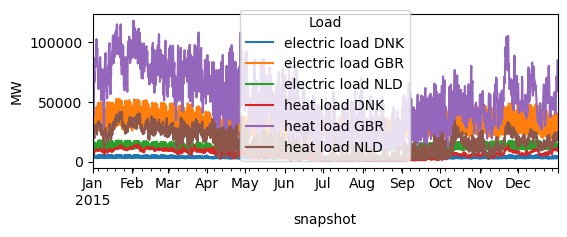

In [733]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

In [734]:
n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus","carrier"]).g.sum()

bus                 carrier     
electrical bus DNK  gas             0.000000e+00
                    nuclear         0.000000e+00
                    offshorewind    5.662583e+07
                    onshorewind     0.000000e+00
                    solar           3.362277e+06
electrical bus GBR  gas             3.051352e+07
                    nuclear         2.572322e+07
                    offshorewind    8.423311e+06
                    onshorewind     3.267235e+08
                    solar           4.802159e+07
electrical bus NLD  gas             8.960166e+06
                    nuclear         1.218327e+06
                    offshorewind    1.622741e+07
                    onshorewind     7.385116e+07
                    solar           2.575980e+07
Name: g, dtype: float64

<Axes: xlabel='snapshot', ylabel='CF'>

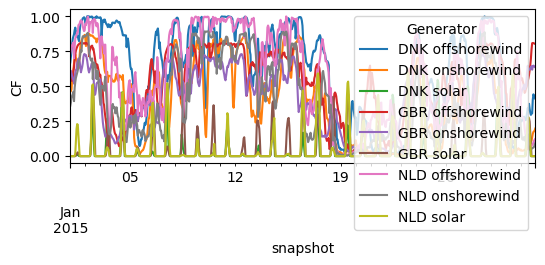

In [735]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

In [736]:
n.links.p_nom_opt

Link
CHP GBR          85145.605277
CHP DNK          23789.130559
CHP NLD          52643.292362
heat pump GBR    39292.185384
heat pump DNK     4393.686230
heat pump NLD    13827.653748
GBR - DNK            0.000000
GBR - NLD        10099.921808
DNK - NLD         3442.620189
Name: p_nom_opt, dtype: float64

In [737]:
n.generators_t.p.sum().div(1e6) 

Generator
GBR onshorewind     326.723485
DNK onshorewind       0.000000
NLD onshorewind      73.851164
GBR offshorewind      8.423311
DNK offshorewind     56.625830
NLD offshorewind     16.227411
GBR CCGT             30.513518
DNK CCGT              0.000000
NLD CCGT              8.960166
GBR solar            48.021592
DNK solar             3.362277
NLD solar            25.759800
GBR nuclear          25.723222
DNK nuclear           0.000000
NLD nuclear           1.218327
dtype: float64

<Axes: xlabel='snapshot', ylabel='MWh'>

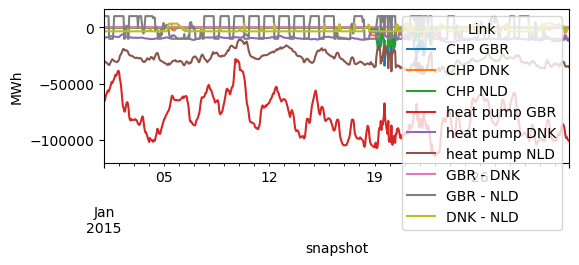

In [738]:
"Electrical Dispatch CHP and Heat Dispatch Heat Pump";
n.links_t.p1.loc["2015-01"].plot(figsize=(6, 2), ylabel="MWh")

In [739]:
"Electrcity Generation CHP";
CHP_el_GBR = n.links_t.p1.loc["2015-01"]["CHP GBR"] # MWh
CHP_el_DNK = n.links_t.p1.loc["2015-01"]["CHP DNK"] # MWh
CHP_el_NLD = n.links_t.p1.loc["2015-01"]["CHP NLD"] # MWh

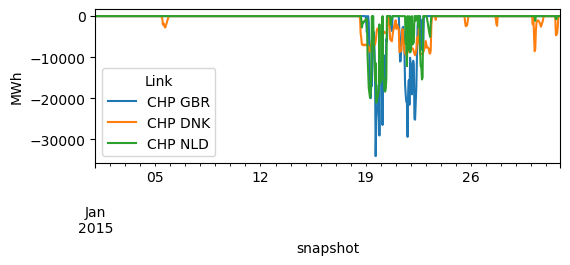

In [740]:
"Heat Dispatch from CHP";
n.links_t.p2.loc["2015-01"].plot(figsize=(6, 2), ylabel="MWh")

CHP_heat_GBR = -n.links_t.p2.loc["2015-01"]["CHP GBR"] # MWh
CHP_heat_DNK = -n.links_t.p2.loc["2015-01"]["CHP DNK"] # MWh
CHP_heat_NLD = -n.links_t.p2.loc["2015-01"]["CHP NLD"] # MWh

In [741]:
-n.links_t.p1["heat pump GBR"]

snapshot
2015-01-01 00:00:00+00:00    64062.547877
2015-01-01 01:00:00+00:00    65383.397149
2015-01-01 02:00:00+00:00    62689.532460
2015-01-01 03:00:00+00:00    60457.750833
2015-01-01 04:00:00+00:00    58777.369771
                                 ...     
2015-12-31 19:00:00+00:00    71894.596165
2015-12-31 20:00:00+00:00    75222.772139
2015-12-31 21:00:00+00:00    78960.353024
2015-12-31 22:00:00+00:00    81803.419959
2015-12-31 23:00:00+00:00    84607.981799
Freq: h, Name: heat pump GBR, Length: 8760, dtype: float64

In [742]:
"Heat Dispatch for Heat Pump";

heatpump_heat_GBR = -n.links_t.p1.loc["2015-01"]["heat pump GBR"] # MWh
heatpump_heat_DNK = -n.links_t.p1.loc["2015-01"]["heat pump DNK"] # MWh
heatpump_heat_NLD = -n.links_t.p1.loc["2015-01"]["heat pump NLD"] # MWh

<Axes: xlabel='snapshot', ylabel='dispatch'>

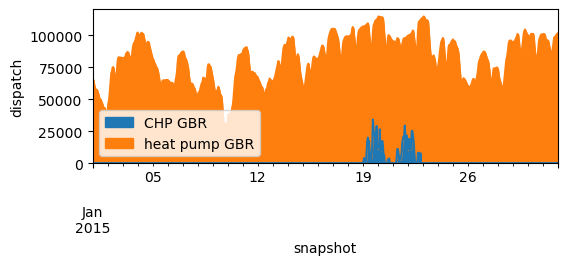

In [743]:
"Heat Dispatch for each country";
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")
#pd.concat([CHP_heat_DNK ,heatpump_heat_DNK],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")
#pd.concat([CHP_heat_NLD ,heatpump_heat_NLD],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")

In [744]:
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).sum()

CHP GBR          8.934109e+05
heat pump GBR    5.968714e+07
dtype: float64

<Axes: title={'center': 'Heat'}>

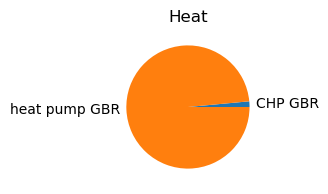

In [745]:
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

<Axes: title={'center': 'Heat'}>

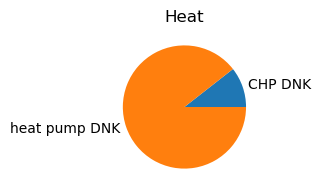

In [746]:
pd.concat([CHP_heat_DNK ,heatpump_heat_DNK],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

<Axes: title={'center': 'Heat'}>

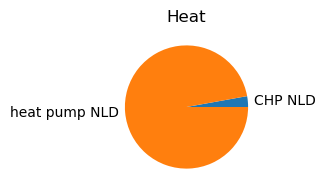

In [747]:
pd.concat([CHP_heat_NLD ,heatpump_heat_NLD],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

In [748]:
gen = n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus","carrier"]).g.sum();

In [749]:
import matplotlib.patches as mpatches

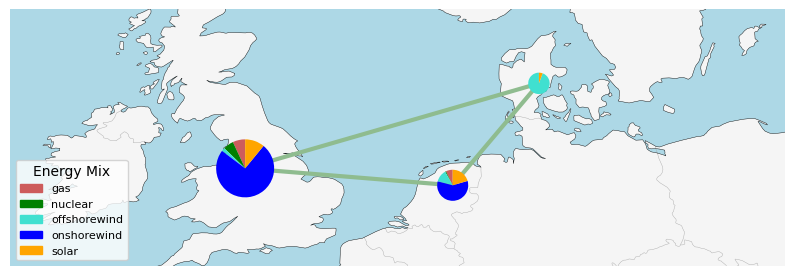

In [750]:
energy_colors = {
    "gas": "indianred",
    "nuclear": "green",
    "offshorewind": "turquoise",
    "onshorewind": "blue",
    "solar": "orange",
}

# Create legend patches
legend_patches = [
    mpatches.Patch(color=color, label=carrier) for carrier, color in energy_colors.items()
]

# Plot the network
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10,10)
)
n.plot(
    bus_sizes=gen / 4e8,
    bus_colors=energy_colors,
    ax=ax,
    color_geomap=True,
    link_widths=3,
    margin=0.76,
)

# Add the legend manually
plt.legend(
    handles=legend_patches,
    loc="lower left",  # Adjust location as needed
    title="Energy Mix",
    fontsize=8,
    title_fontsize=10,
)

<Axes: title={'center': 'Generation Mix by Carrier'}, xlabel='bus'>

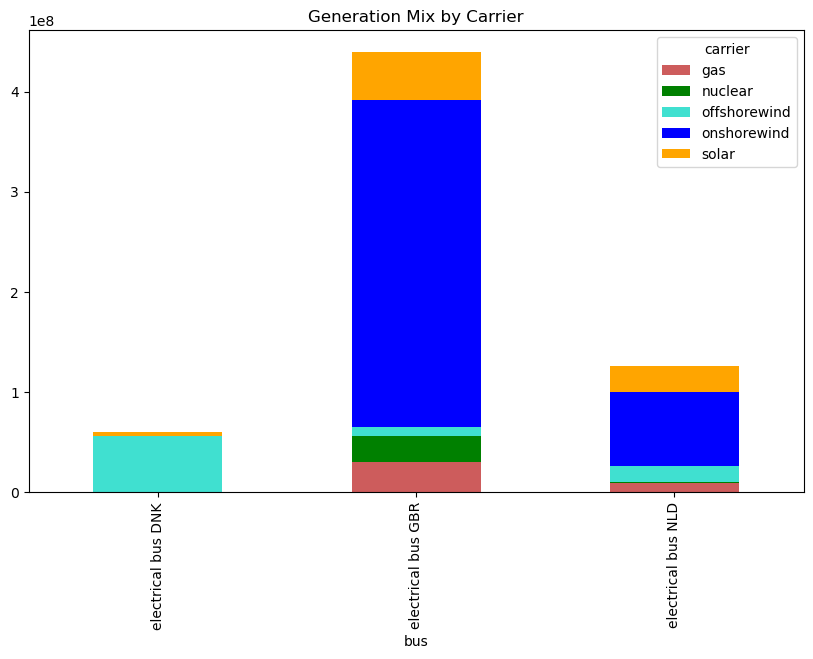

In [751]:
gen.unstack(level='carrier').fillna(0).plot(kind='bar', stacked=True, figsize=(10, 6),color=energy_colors.values(), title="Generation Mix by Carrier")

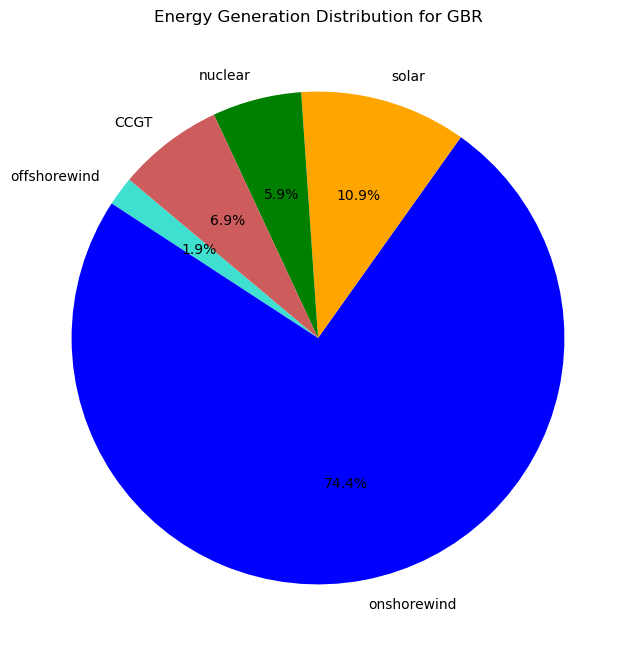

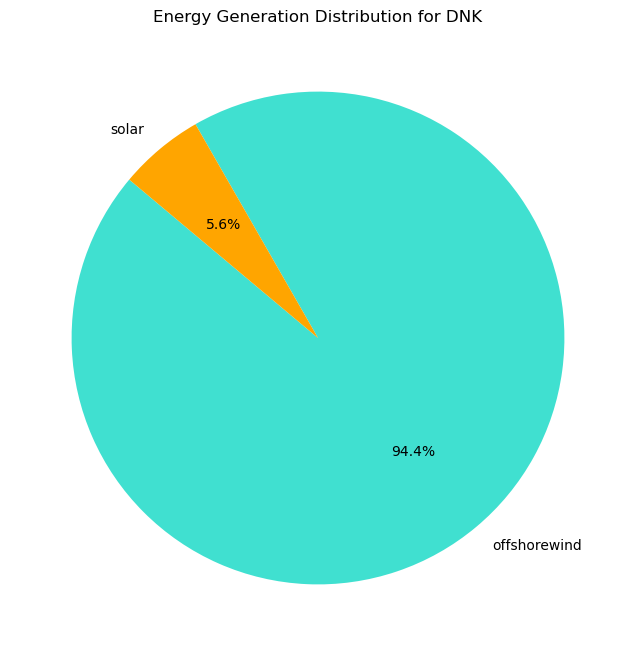

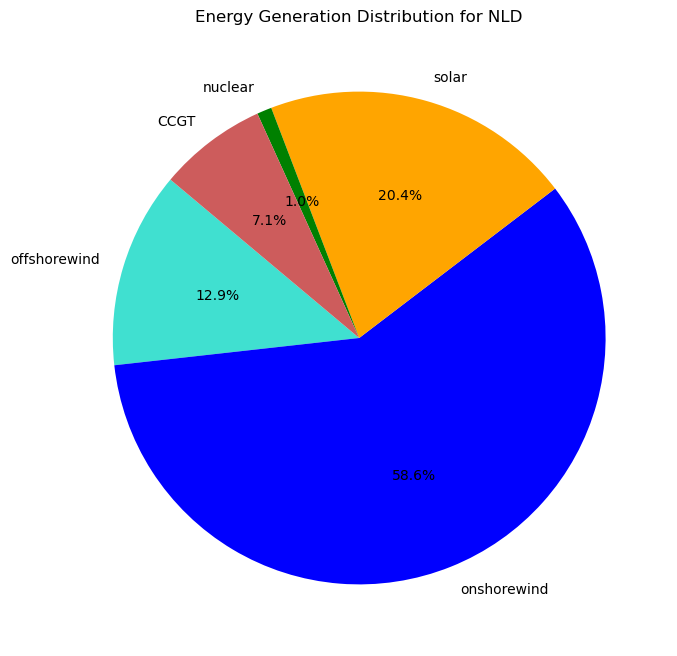

In [752]:
import matplotlib.pyplot as plt

# List of countries
countries = ['GBR', 'DNK', 'NLD']

# List of energy sources
energy_sources = ['offshorewind', 'onshorewind', 'solar', 'nuclear', 'CCGT']

# Colors for the pie chart
colors = ['turquoise','blue', 'orange', 'green', 'indianred']

# Loop through each country
for country in countries:
    # Calculate the generation sums for each energy source
    sizes = [n.generators_t.p[f"{country} {source}"].sum() for source in energy_sources]
    
    # Filter out sources with approximately zero contribution
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [energy_sources[i] for i in range(len(sizes)) if sizes[i] > 0]
    filtered_colors = [colors[i] for i in range(len(sizes)) if sizes[i] > 0]
    
    # Create the pie chart
    if filtered_sizes:  # Only plot if there are non-zero contributions
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=filtered_colors)
        plt.title(f'Energy Generation Distribution for {country}')
        plt.show()

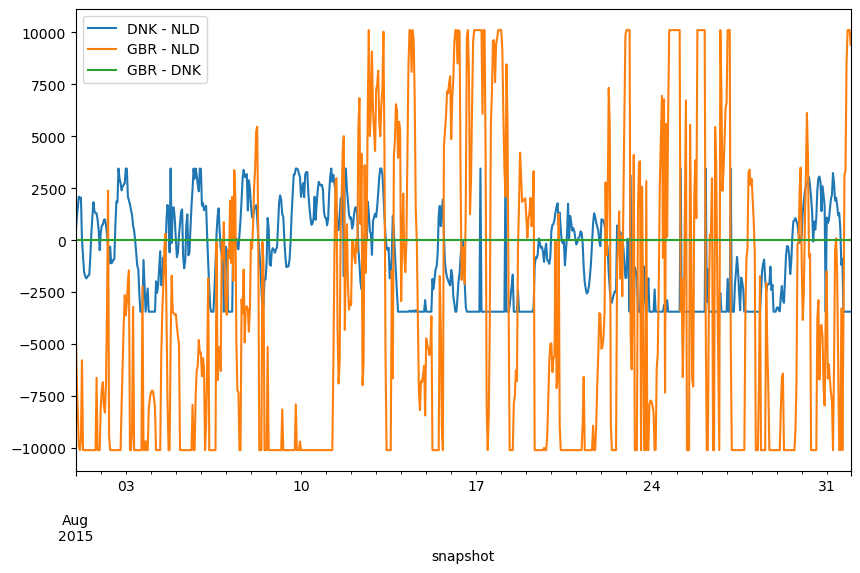

In [753]:
plt.figure(figsize=(10, 6))
n.links_t.p1.loc["2015-08"]["DNK - NLD"].plot(label="DNK - NLD")
n.links_t.p1.loc["2015-08"]["GBR - NLD"].plot(label ="GBR - NLD")
n.links_t.p1.loc["2015-08"]["GBR - DNK"].plot(label = "GBR - DNK")
plt.legend()


In [754]:
n

PyPSA Network
Components:
 - Bus: 9
 - Carrier: 7
 - Generator: 15
 - GlobalConstraint: 1
 - Link: 9
 - Load: 6
 - Store: 3
 - SubNetwork: 9
Snapshots: 8760